In [ ]:
import os
import shutil

# Directorios base
base_dir = "D:/PUCP/2024-1/Deep Learning/Trabajo Final/gtFine"
splits = ['train', 'val', 'test']
types = ['color', 'instanceIds', 'labelIds', 'polygons']

# Crear directorios para cada split y tipo de imagen
for split in splits:
    for image_type in types:
        dir_path = os.path.join(base_dir, split, image_type)
        os.makedirs(dir_path, exist_ok=True)

# Función para mover archivos
def move_files(split, city):
    city_dir = os.path.join(base_dir, split, city)
    files = os.listdir(city_dir)

    for file in files:
        if file.endswith("_gtFine_color.png"):
            shutil.move(os.path.join(city_dir, file), os.path.join(base_dir, split, 'color', file))
        elif file.endswith("_gtFine_instanceIds.png"):
            shutil.move(os.path.join(city_dir, file), os.path.join(base_dir, split, 'instanceIds', file))
        elif file.endswith("_gtFine_labelIds.png"):
            shutil.move(os.path.join(city_dir, file), os.path.join(base_dir, split, 'labelIds', file))
        elif file.endswith("_gtFine_polygons.json"):
            shutil.move(os.path.join(city_dir, file), os.path.join(base_dir, split, 'polygons', file))

# Iterar sobre cada split y cada ciudad
for split in splits:
    split_dir = os.path.join(base_dir, split)
    cities = os.listdir(split_dir)

    for city in cities:
        city_dir = os.path.join(split_dir, city)
        if os.path.isdir(city_dir):
            move_files(split, city)

print("Archivos organizados correctamente.")

Archivos organizados correctamente.


In [ ]:
import torch

# Comprobar si CUDA está disponible
if torch.cuda.is_available():
    print("CUDA está disponible. Usando GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA no está disponible. Usando CPU.")

CUDA está disponible. Usando GPU: NVIDIA GeForce RTX 3060 Laptop GPU


## Intento

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

#Definición de la clase ciyscapes
class CityscapesDataset(Dataset):
    #Inicialización de la clase
    def __init__(self, root_dir, split, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.target_transform = target_transform
        self.image_dir = os.path.join(root_dir, 'color')
        self.mask_dir = os.path.join(root_dir, 'labelIds')
        self.images = sorted(os.listdir(self.image_dir))
        self.masks = sorted(os.listdir(self.mask_dir))


    # Retorna el número de imagenes en el dataset
    def __len__(self):
        return len(self.images)

  # Retorna la imagen del indice especificado.
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

# Funcion de redimencionamiento de imagenes
def target_transform(mask):
    mask = mask.resize((128, 128), Image.NEAREST)
    return torch.tensor(np.array(mask), dtype=torch.long)


# Definicion del modelo FCN (Fully Convolutional Neural Network)
class FCN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(FCN, self).__init__()

        #Definición de capas convolucioinales
        self.conv1 = nn.Conv2d(n_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)

        #Definicion de capas transpuestas para upsampling
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.conv10 = nn.Conv2d(64, n_classes, kernel_size=1)


        # Capa de maxpooling
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):

        # Paso por capas conovlucionales y pooling
        x1 = self.pool(F.relu(self.conv1(x)))  # [B, 64, 64, 64]
        x2 = self.pool(F.relu(self.conv2(x1)))  # [B, 128, 32, 32]
        x3 = self.pool(F.relu(self.conv3(x2)))  # [B, 256, 16, 16]
        x4 = self.pool(F.relu(self.conv4(x3)))  # [B, 512, 8, 8]
        x5 = self.pool(F.relu(self.conv5(x4)))  # [B, 1024, 4, 4]

        x6 = F.relu(self.conv6(self.up1(x5)))  # [B, 512, 8, 8]
        x7 = F.relu(self.conv7(self.up2(x6)))  # [B, 256, 16, 16]
        x8 = F.relu(self.conv8(self.up3(x7)))  # [B, 128, 32, 32]
        x9 = F.relu(self.conv9(self.up4(x8)))  # [B, 64, 64, 64]
        x10 = self.conv10(x9)  # [B, n_classes, 64, 64]

        # Para ajustar el tamaño de salida
        return F.interpolate(x10, size=(128, 128), mode='bilinear', align_corners=False)  # [B, n_classes, 128, 128]

# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Crear datasets y dataloaders
base_dir = 'D:/PUCP/2024-1/Deep Learning/Trabajo Final/gtFine/train'
base_dir_val = 'D:/PUCP/2024-1/Deep Learning/Trabajo Final/gtFine/val'
train_dataset = CityscapesDataset(base_dir, 'train', transform=transform, target_transform=target_transform)
val_dataset = CityscapesDataset(base_dir_val, 'val', transform=transform, target_transform=target_transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

# Instanciar el modelo FCN
model = FCN(n_channels=3, n_classes=34)

# Mover el modelo a GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Función para calcular IoU
def calculate_iou(pred, target, n_classes):
    ious = []
    pred = torch.argmax(pred, dim=1)
    for cls in range(n_classes):
        intersection = torch.sum((pred == cls) & (target == cls))
        union = torch.sum((pred == cls) | (target == cls))
        if union == 0:
            ious.append(float('nan'))  #Evitar división entre cero
        else:
            ious.append(float(intersection) / float(union))
    return np.nanmean(ious)  #Evitar clases sin predicciones

# Función de evaluación
def evaluate(model, loader, criterion, device, n_classes):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            total_iou += calculate_iou(outputs, masks, n_classes)
    return total_loss / len(loader), total_iou / len(loader)

# Función de entrenamiento
def train(model, train_loader, val_loader, criterion, optimizer, device, n_classes, num_epochs):
    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_iou = 0.0
        total_batches = len(train_loader)

        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_iou += calculate_iou(outputs, masks, n_classes)

            # Seguimiento del progreso
            if batch_idx % 10 == 0:
                print(f'Batch {batch_idx}/{total_batches}, Loss: {loss.item():.4f}')

        train_loss = running_loss / total_batches
        train_iou = running_iou / total_batches
        val_loss, val_iou = evaluate(model, val_loader, criterion, device, n_classes)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_ious.append(train_iou)
        val_ious.append(val_iou)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}")

    return train_losses, val_losses, train_ious, val_ious

# Entrenar el modelo
num_epochs = 10
train_losses, val_losses, train_ious, val_ious = train(model, train_loader, val_loader, criterion, optimizer, device, n_classes=34, num_epochs=num_epochs)

In [ ]:
# Guardar el modelo
torch.save(model.state_dict(), 'fcn_model.pth')
print("Entrenamiento completado y modelo guardado.")

Entrenamiento completado y modelo guardado.


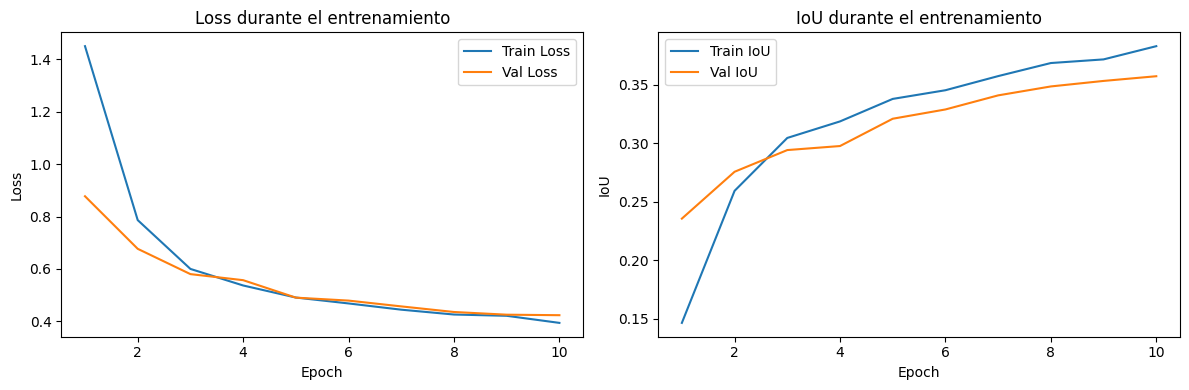

In [ ]:
# Visualizar las métricas
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss durante el entrenamiento')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_ious, label='Train IoU')
plt.plot(epochs, val_ious, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('IoU durante el entrenamiento')

plt.tight_layout()
plt.show()

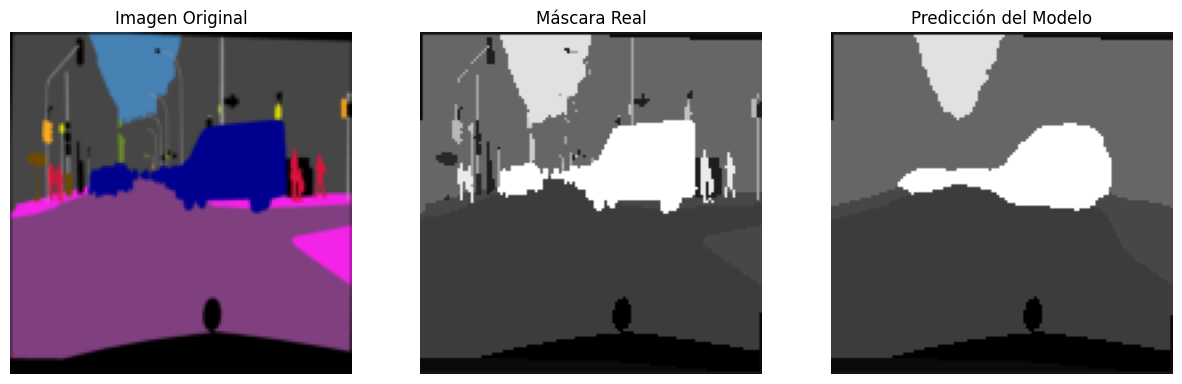

In [ ]:
import random
import matplotlib.pyplot as plt

base_dir_test = 'D:/PUCP/2024-1/Deep Learning/Trabajo Final/gtFine/test'
test_dataset = CityscapesDataset(base_dir_test, 'test', transform=transform, target_transform=target_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

# Función para mostrar una imagen, su máscara real y su predicción
def visualize_prediction(model, dataset, device):
    model.eval()

    # Seleccionar aleatoriamente un índice
    idx = random.randint(0, len(dataset) - 1)

    # Obtener la imagen y la máscara correspondientes
    image, mask = dataset[idx]
    image = image.unsqueeze(0).to(device)  # Añadir dimensión de batch y mover a device

    # Realizar la predicción
    with torch.no_grad():
        output = model(image)
    prediction = torch.argmax(output, dim=1).cpu().squeeze(0).numpy()  # Obtener la clase predicha

    image = image.cpu().squeeze(0).permute(1, 2, 0).numpy()  # Convertir imagen a formato numpy para visualizar
    mask = mask.numpy()

    # Mostrar la imagen original, la máscara real y la predicción
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title('Imagen Original')
    axs[0].axis('off')

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('Máscara Real')
    axs[1].axis('off')

    axs[2].imshow(prediction, cmap='gray')
    axs[2].set_title('Predicción del Modelo')
    axs[2].axis('off')

    plt.show()

# Visualizar una predicción aleatoria del conjunto de test
visualize_prediction(model, val_dataset, device)

## Optimización

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import random

#Definición de la clase ciyscapes
class CityscapesDataset(Dataset):

        #Inicialización de la clase
    def __init__(self, root_dir, split, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.target_transform = target_transform
        self.image_dir = os.path.join(root_dir, 'color')
        self.mask_dir = os.path.join(root_dir, 'labelIds')
        self.images = sorted(os.listdir(self.image_dir))
        self.masks = sorted(os.listdir(self.mask_dir))

        # Retorna el número de imagenes en el dataset
    def __len__(self):
        return len(self.images)

  # Retorna la imagen del indice especificado.
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

# Funcion de redimencionamiento de imagenes
def target_transform(mask):
    mask = mask.resize((128, 128), Image.NEAREST)
    return torch.tensor(np.array(mask), dtype=torch.long)

# Definicion del modelo FCN (Fully Convolutional Neural Network)

class FCN(nn.Module):
    def __init__(self, n_channels, n_classes, base_filters):
        super(FCN, self).__init__()

        #Definición de capas convolucionales
        self.conv1 = nn.Conv2d(n_channels, base_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(base_filters, base_filters * 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(base_filters * 2, base_filters * 4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(base_filters * 4, base_filters * 8, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(base_filters * 8, base_filters * 16, kernel_size=3, padding=1)

        #Definicion de capas transpuestas para upsampling
        self.up1 = nn.ConvTranspose2d(base_filters * 16, base_filters * 8, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(base_filters * 8, base_filters * 8, kernel_size=3, padding=1)
        self.up2 = nn.ConvTranspose2d(base_filters * 8, base_filters * 4, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(base_filters * 4, base_filters * 4, kernel_size=3, padding=1)
        self.up3 = nn.ConvTranspose2d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(base_filters * 2, base_filters * 2, kernel_size=3, padding=1)
        self.up4 = nn.ConvTranspose2d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(base_filters, base_filters, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(base_filters, n_classes, kernel_size=1)

        # Capa de maxpooling
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x1 = self.pool(F.relu(self.conv1(x)))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.pool(F.relu(self.conv3(x2)))
        x4 = self.pool(F.relu(self.conv4(x3)))
        x5 = self.pool(F.relu(self.conv5(x4)))

        x6 = F.relu(self.conv6(self.up1(x5)))
        x7 = F.relu(self.conv7(self.up2(x6)))
        x8 = F.relu(self.conv8(self.up3(x7)))
        x9 = F.relu(self.conv9(self.up4(x8)))
        x10 = self.conv10(x9)

        # Para ajustar tamaño de salida
        return F.interpolate(x10, size=(128, 128), mode='bilinear', align_corners=False)


# Funcion para realizar el calculo de métrica IOU
def calculate_iou(pred, target, n_classes):
    ious = []
    pred = torch.argmax(pred, dim=1)
    for cls in range(n_classes):
        intersection = torch.sum((pred == cls) & (target == cls))
        union = torch.sum((pred == cls) | (target == cls))
        if union == 0:
            ious.append(float('nan'))  # evitar división por cero
        else:
            ious.append(float(intersection) / float(union))
    return np.nanmean(ious)  # evitar clases sin predicciones

def evaluate(model, loader, criterion, device, n_classes):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            total_iou += calculate_iou(outputs, masks, n_classes)
    return total_loss / len(loader), total_iou / len(loader)

def train(model, train_loader, val_loader, criterion, optimizer, device, n_classes, num_epochs):
    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []

    best_val_iou = 0
    best_model_weights = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_iou = 0.0
        total_batches = len(train_loader)

        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_iou += calculate_iou(outputs, masks, n_classes)

            if batch_idx % 10 == 0:
                print(f'Batch {batch_idx}/{total_batches}, Loss: {loss.item():.4f}')

        train_loss = running_loss / total_batches
        train_iou = running_iou / total_batches
        val_loss, val_iou = evaluate(model, val_loader, criterion, device, n_classes)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_ious.append(train_iou)
        val_ious.append(val_iou)

        # Guardar los pesos del mejor modelo
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            best_model_weights = model.state_dict()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}")

    # Retornar los mejores pesos además de las métricas
    return train_losses, val_losses, train_ious, val_ious, best_model_weights

# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Crear datasets y dataloaders
base_dir = 'D:/PUCP/2024-1/Deep Learning/Trabajo Final/gtFine/train'
base_dir_val = 'D:/PUCP/2024-1/Deep Learning/Trabajo Final/gtFine/val'
train_dataset = CityscapesDataset(base_dir, 'train', transform=transform, target_transform=target_transform)
val_dataset = CityscapesDataset(base_dir_val, 'val', transform=transform, target_transform=target_transform)

# Definir combinaciones de hiperparámetros
hyperparameter_combinations = [
    {'batch_size': 4, 'filters': 64, 'learning_rate': 0.001},
    {'batch_size': 4, 'filters': 128, 'learning_rate': 0.001},
    {'batch_size': 4, 'filters': 64, 'learning_rate': 0.0001},
    {'batch_size': 4, 'filters': 128, 'learning_rate': 0.0001},
    {'batch_size': 8, 'filters': 64, 'learning_rate': 0.001}
]

results = []

best_model_weights = None
best_val_iou = 0

for config in hyperparameter_combinations:
    print(f"Training with config: {config}")
    batch_size = config['batch_size']
    filters = config['filters']
    learning_rate = config['learning_rate']

    # Crear datasets y dataloaders con el batch size actual
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Instanciar el modelo con el número de filtros actual
    model = FCN(n_channels=3, n_classes=34, base_filters=filters)
    model = model.to(device)

    # Definir el optimizador con el learning rate actual
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Entrenar el modelo y medir el tiempo de entrenamiento
    start_time = time.time()
    train_losses, val_losses, train_ious, val_ious, best_weights = train(model, train_loader, val_loader, criterion,
                                                                         optimizer, device, n_classes=34, num_epochs=10)
    end_time = time.time()

    # Guardar los resultados
    results.append({
        'config': config,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_ious': train_ious,
        'val_ious': val_ious,
        'training_time': end_time - start_time
    })

    # Actualizar los mejores pesos si es necesario
    if max(val_ious) > best_val_iou:
        best_val_iou = max(val_ious)
        best_model_weights = best_weights

# Guardar el mejor modelo
torch.save(best_model_weights, 'best_model.pth')

Training with config: {'batch_size': 4, 'filters': 64, 'learning_rate': 0.001}
Batch 0/744, Loss: 3.5226
Batch 10/744, Loss: 3.4435
Batch 20/744, Loss: 3.3984
Batch 30/744, Loss: 3.0551
Batch 40/744, Loss: 2.5027
Batch 50/744, Loss: 2.1848
Batch 60/744, Loss: 2.0632
Batch 70/744, Loss: 2.2238
Batch 80/744, Loss: 2.2794
Batch 90/744, Loss: 1.8682
Batch 100/744, Loss: 2.0859
Batch 110/744, Loss: 2.0888
Batch 120/744, Loss: 2.1366
Batch 130/744, Loss: 2.2421
Batch 140/744, Loss: 1.7006
Batch 150/744, Loss: 1.9047
Batch 160/744, Loss: 2.0962
Batch 170/744, Loss: 1.6330
Batch 180/744, Loss: 1.4684
Batch 190/744, Loss: 1.6173
Batch 200/744, Loss: 1.6948
Batch 210/744, Loss: 1.4115
Batch 220/744, Loss: 1.3650
Batch 230/744, Loss: 1.6451
Batch 240/744, Loss: 1.2845
Batch 250/744, Loss: 1.5030
Batch 260/744, Loss: 1.5894
Batch 270/744, Loss: 1.5280
Batch 280/744, Loss: 1.1397
Batch 290/744, Loss: 1.2289
Batch 300/744, Loss: 1.1866
Batch 310/744, Loss: 1.3066
Batch 320/744, Loss: 1.3030
Batch 33

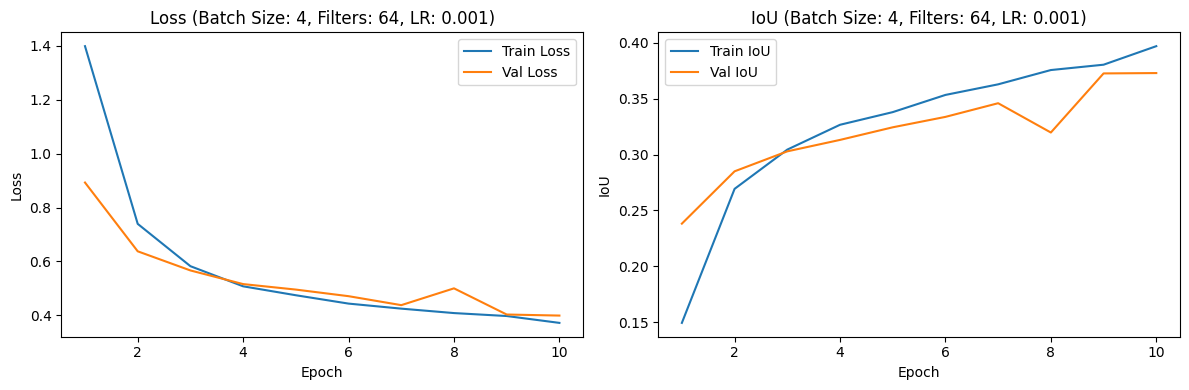

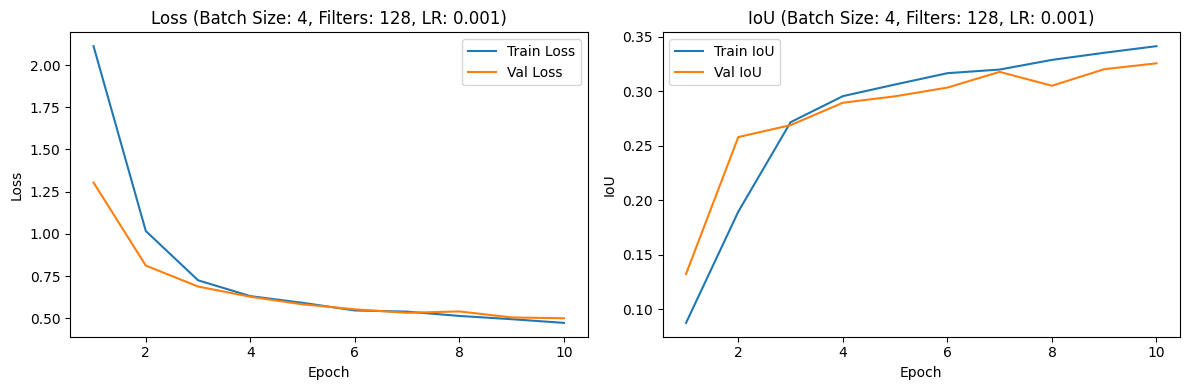

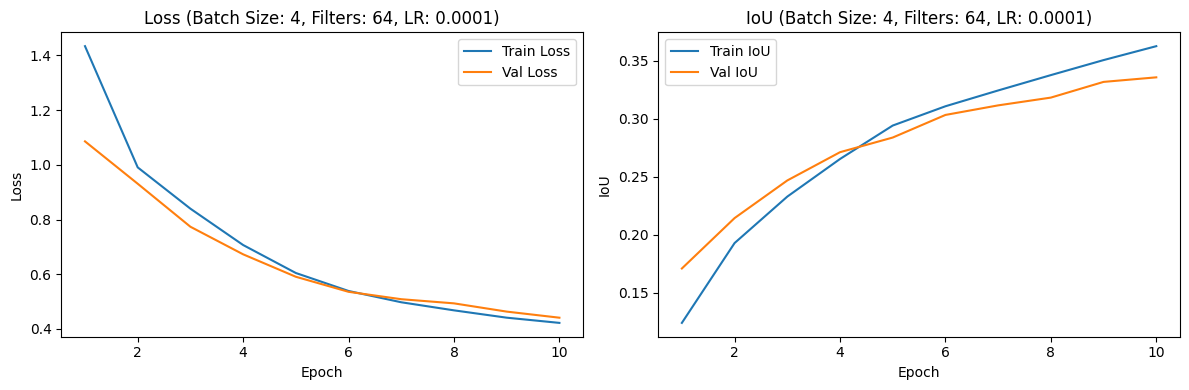

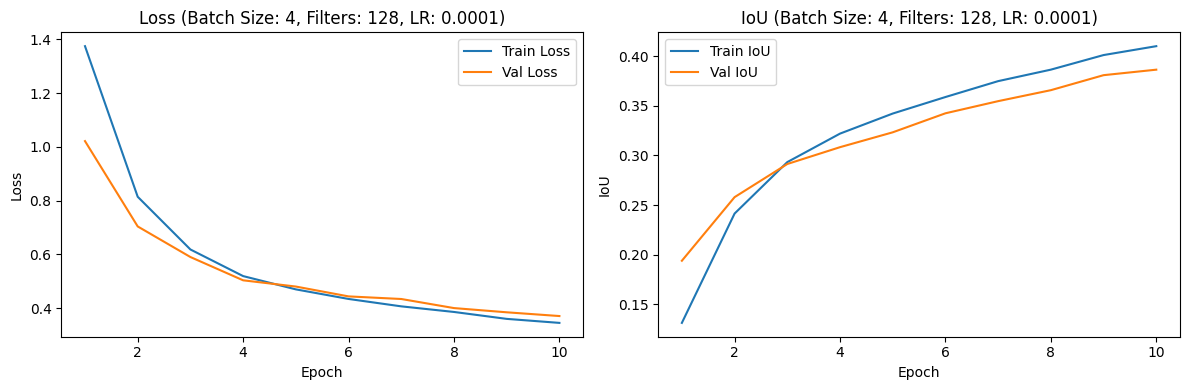

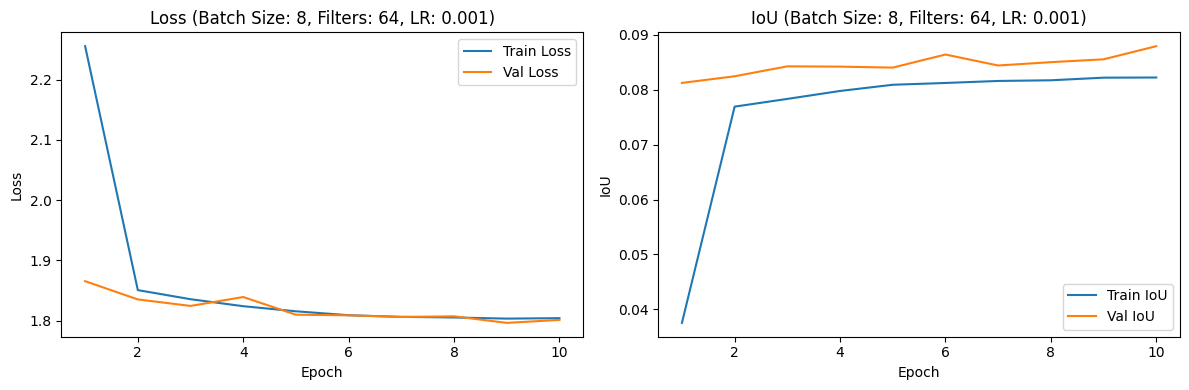

In [ ]:
# Visualizar las métricas para cada configuración
for result in results:
    config = result['config']
    epochs = range(1, len(result['train_losses']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, result['train_losses'], label='Train Loss')
    plt.plot(epochs, result['val_losses'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Loss (Batch Size: {config['batch_size']}, Filters: {config['filters']}, LR: {config['learning_rate']})")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, result['train_ious'], label='Train IoU')
    plt.plot(epochs, result['val_ious'], label='Val IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.title(f"IoU (Batch Size: {config['batch_size']}, Filters: {config['filters']}, LR: {config['learning_rate']})")

    plt.tight_layout()
    plt.show()

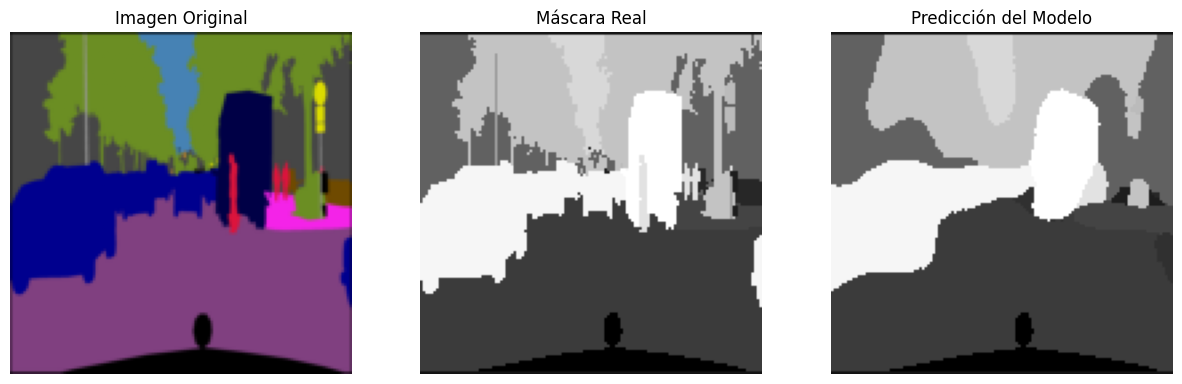

In [ ]:
import random
import matplotlib.pyplot as plt

# Cargar el mejor modelo
best_model = FCN(n_channels=3, n_classes=34, base_filters=128)  # Ajustar 'base_filters' según sea necesario
best_model.load_state_dict(torch.load('best_model.pth'))
best_model = best_model.to(device)

base_dir_test = 'D:/PUCP/2024-1/Deep Learning/Trabajo Final/gtFine/val'
test_dataset = CityscapesDataset(base_dir_test, 'test', transform=transform, target_transform=target_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

# Función para mostrar una imagen, su máscara real y su predicción
def visualize_prediction(model, dataset, device):
    model.eval()

    # Seleccionar aleatoriamente un índice
    idx = random.randint(0, len(dataset) - 1)

    # Obtener la imagen y la máscara correspondientes
    image, mask = dataset[idx]
    image = image.unsqueeze(0).to(device)  # Añadir dimensión de batch y mover a device

    # Realizar la predicción
    with torch.no_grad():
        output = model(image)
    prediction = torch.argmax(output, dim=1).cpu().squeeze(0).numpy()  # Obtener la clase predicha

    image = image.cpu().squeeze(0).permute(1, 2, 0).numpy()  # Convertir imagen a formato numpy para visualizar
    mask = mask.numpy()

    # Mostrar la imagen original, la máscara real y la predicción
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title('Imagen Original')
    axs[0].axis('off')

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('Máscara Real')
    axs[1].axis('off')

    axs[2].imshow(prediction, cmap='gray')
    axs[2].set_title('Predicción del Modelo')
    axs[2].axis('off')

    plt.show()

# Visualizar una predicción aleatoria del conjunto de test
visualize_prediction(best_model, test_dataset, device)